# BayesOPT Example for showing Gittins >> EIpu
Extension of the numerical examples presented in Theorem 1 of Raul and Peter's paper which aims to show the limitation of EIpu and EI. The experiment extends the scope from Pandora's box (discrete finite points) to Bayesian optimization (continuous domain) and compares Gittins with EIpu/EI.

In [1]:
import torch
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

## Define the amplitude function and the cost function 
The continuous amplitude function and the continuous cost function are constructed based on the variances and costs of the discrete finite points provided in the original example

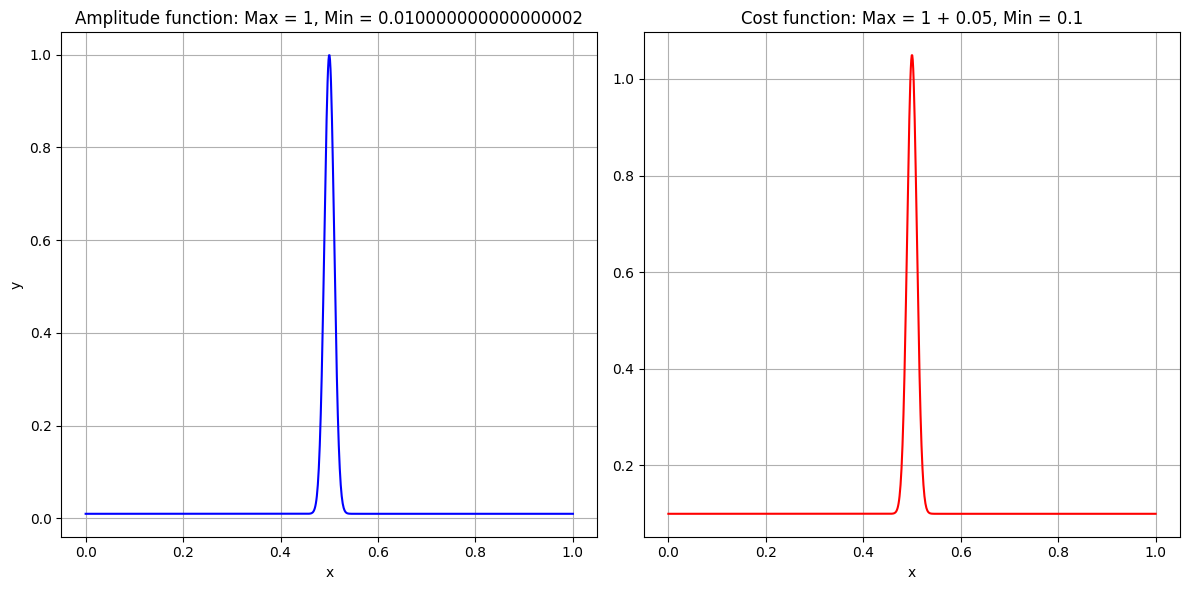

In [2]:
import matplotlib.pyplot as plt
# Define typical small values for epsilon and delta, and a moderate value for K
epsilon = 0.1
delta = 0.05
K = 100  # Number of points excluding the central point

# Define the functions for the amplitude and the cost
def amplitude_function(x):
    width = 1.0 / K  # Width of the bump to cover only the central point
    outputscale = torch.exp(-((x - 0.5)**2) / (2 * width**2)) * (1 - epsilon**2) + epsilon**2
    return outputscale.squeeze(-1)

def cost_function(x):
    width = 1.0 / K  # Width of the bump to cover only the central point
    peak_height = 1 + delta - epsilon
    cost = torch.exp(-((x - 0.5)**2) / (2 * width**2)) * peak_height + epsilon
    return cost.squeeze(-1)

# Generate x values from 0 to 1
x_values = torch.linspace(0, 1, 1000)

# Generate y values for both cases
y_values_amplitude = [amplitude_function(x) for x in x_values]
y_values_cost = [cost_function(x) for x in x_values]

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for Case One
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for Case Two
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {delta}, Min = {epsilon}")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

### TODO
Adjust the hyperparamters to get a larger discrepancy between EIpu and Gittins

### Question
Is it necessary to pass epsilon = 0.1, delta = 0.05, K = 100 as parameters to amplitude_function and cost_function?

## Define the objective function
The objective functions are constructed as sample paths drawn from the Matern kernel multiplied by the amplitude function

In [3]:
from pandora_bayesopt.utils import create_objective_function
# Create the objective model
dim = 1
nu = 0.5
lengthscale = 0.01
outputscale = 1.0
num_rff_features = 1280
seed = 42
torch.manual_seed(seed)
def objective_Matern(x):
    Matern_sample = create_objective_function(dim, nu, lengthscale, outputscale, num_rff_features, seed)
    return Matern_sample(x)
def objective_function(x):
    Matern_sample = create_objective_function(dim, nu, lengthscale, outputscale, num_rff_features, seed)
    return Matern_sample(x) * amplitude_function(x)

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


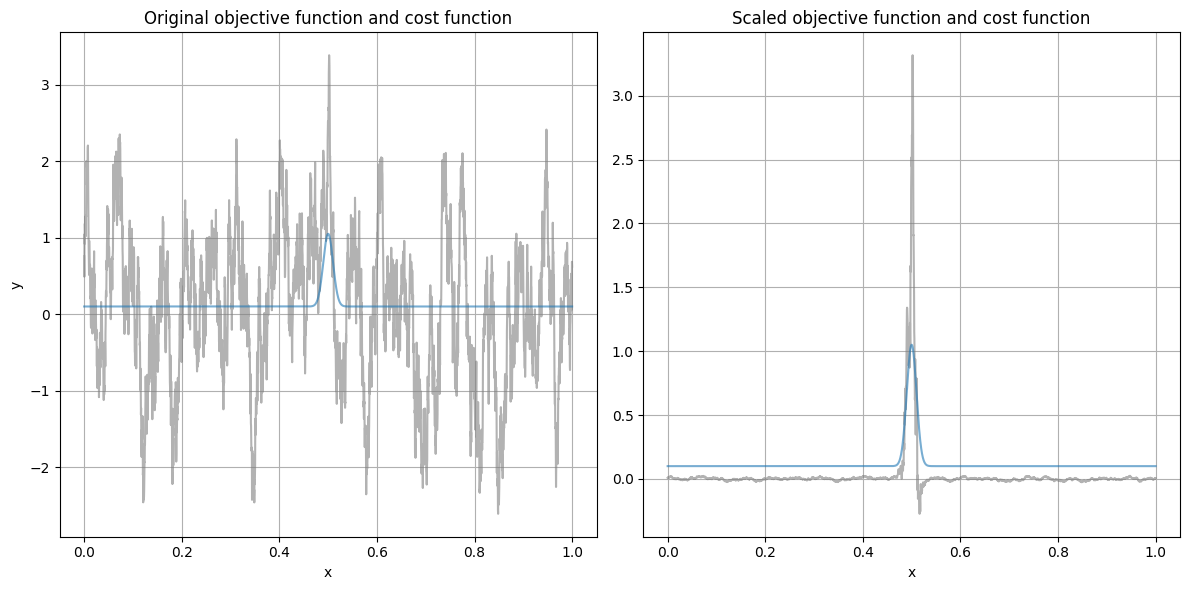

In [4]:
test_x = torch.linspace(0, 1, 3001, dtype=torch.float64, device=device)

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for original objective function
plt.subplot(1, 2, 1)
plt.plot(test_x.cpu().numpy(), objective_Matern(test_x.view(-1,1)).numpy(), color='tab:grey', label="Original objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Original objective function and cost function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for scaled objective function
plt.subplot(1, 2, 2)
plt.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), color='tab:grey', label="Scaled objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Scaled objective function and cost function")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        
    
    ax.legend(['Objective Function', 'Observed Data', 'Mean', 'Confidence'])

### Define a customized kernel as Matern kernel with input-dependent amplitude (outputscale)

In [6]:
from pandora_bayesopt.kernel import VariableAmplitudeKernel

### Note
This class can be found in pandora_bayesopt.kernel

## Fit a GP model with observation data and a specified kernel

In [7]:
from pandora_bayesopt.utils import fit_gp_model

### Note
This function can be found in pandora_bayesopt.utils

### Question
Instead of setting the kernel inside fit_gp_model with given smoothness and lengthscale parameters, I set the kernel before running the BayesOPT loop so that I can also use fit_gp_model with a standard Matern kernel (base_kernel) for other tasks. However, it seems that if I only set it once, then it would be a different initial kernel when I run another policy. Not sure why this happens. To avoid such issues, I reset it before running every policy.

## Test EI policy

best oberved value: 0.007566416789224684
Iteration 0, measuring at x=0.4999999991848119, y=2.4492252231369083


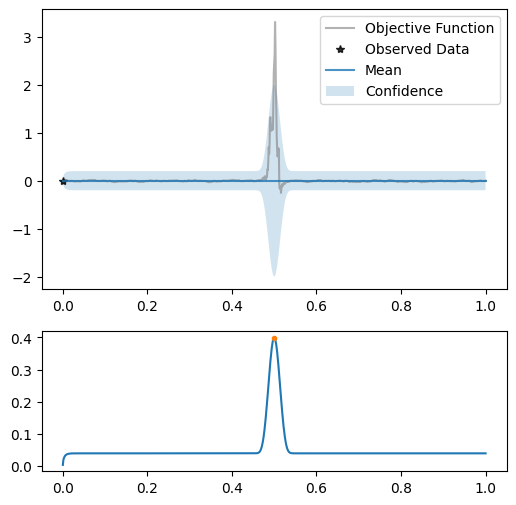

best oberved value: 2.4492252231369083
new cost: 1.049999999999997
cumulative cost: 1.049999999999997
Iteration 1, measuring at x=0.5009517829416819, y=2.692459231784037


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2284]), std = tensor([1.7265])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


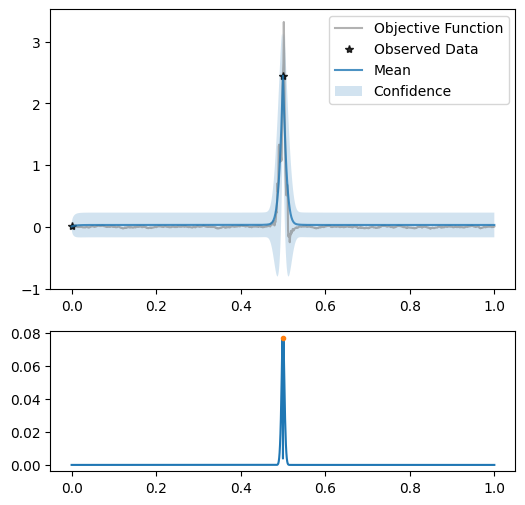

best oberved value: 2.692459231784037
new cost: 1.0457067492322334
cumulative cost: 2.0957067492322303


In [8]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.kernels import MaternKernel

maximize = True
dim = 1
budget = 1+delta

x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EI_cumulative_cost_history = [0]

i = 0

# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]], dtype=torch.float64)
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Plot the posterior and the EI
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    test_x = torch.linspace(0, 1, 1001, dtype=torch.float64, device=device)
    
    # Plot the posterior
    plot_posterior(ax1,objective_function,model,test_x,x,y)
    
    # Plot EI
    acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'.')
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### Question
- Do I need to care about these warnings?

## Test EI per unit cost policy

best oberved value: 0.007566416789224684
Iteration 0, measuring at x=0.522200831164171, y=-0.043819302818363666


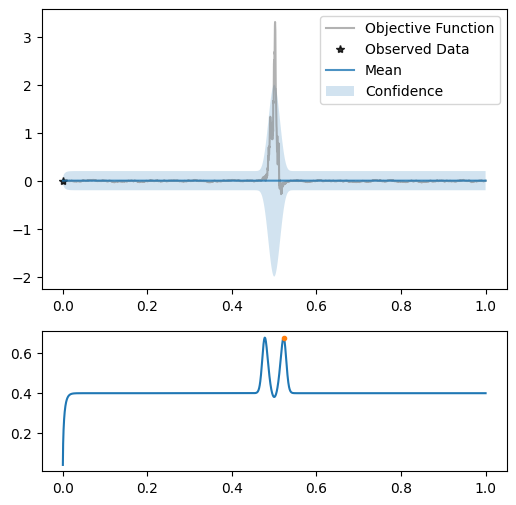

best oberved value: 0.007566416789224684
new cost: 0.18080812057916637
cumulative cost: 0.18080812057916637
Iteration 1, measuring at x=0.47797728887379093, y=0.10556462055029704


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0181]), std = tensor([0.0363])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


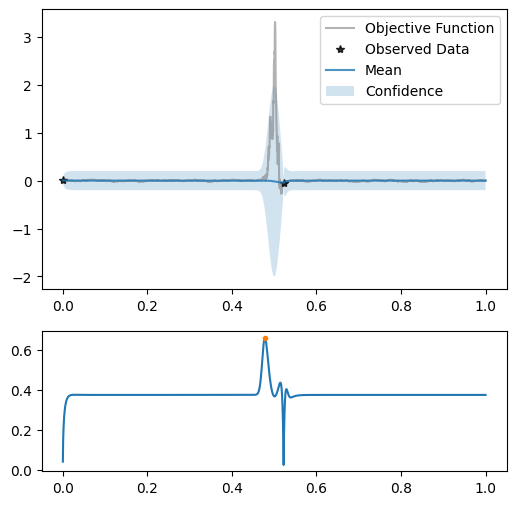

best oberved value: 0.10556462055029704
new cost: 0.18405429489643588
cumulative cost: 0.3648624154756023
Iteration 2, measuring at x=0.48169051664363555, y=0.14412197141606


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0231]), std = tensor([0.0759])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


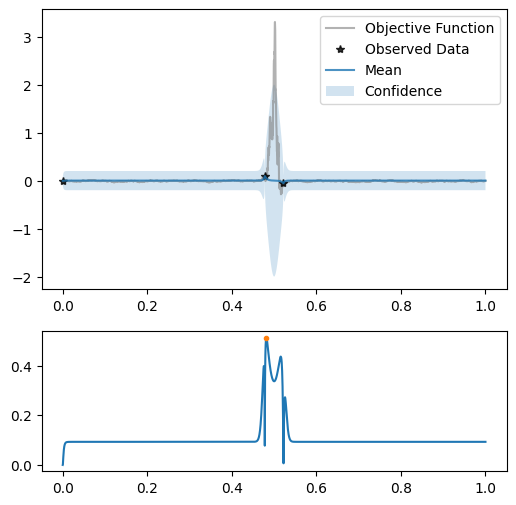

best oberved value: 0.14412197141606
new cost: 0.2777318725620812
cumulative cost: 0.6425942880376835
Iteration 3, measuring at x=0.4886224514548406, y=0.7274283554856026


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0534]), std = tensor([0.0866])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


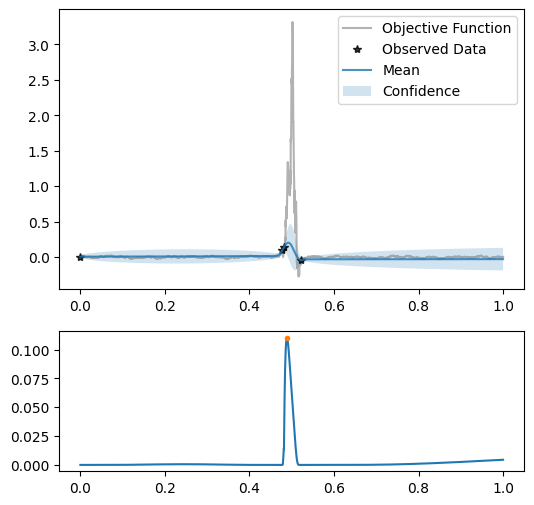

best oberved value: 0.7274283554856026
new cost: 0.597312663600692
cumulative cost: 1.2399069516383756


In [9]:
from pandora_bayesopt.acquisition import ExpectedImprovementWithCost

maximize = True
dim = 1
budget = 1+delta

x = torch.zeros(dim).unsqueeze(-1)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()
EIpu_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EIpu_cumulative_cost_history = [0]

i = 0

# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]], dtype=torch.float64)
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EIpu
    EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
    new_point, new_point_EIpu = optimize_acqf(
        acq_function=EIpu,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Plot the posterior and the EIpu
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    test_x = torch.linspace(0, 1, 3001, dtype=torch.float64, device=device)
    
    # Plot the posterior
    plot_posterior(ax1,objective_function,model,test_x,x,y)
    
    # Plot EIpu
    acq = EIpu.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EIpu.numpy(),'.')
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EIpu_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EIpu_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### TODO
- Test EI with cost cooling as well

## Test Hyperparamter-free Gittins policy

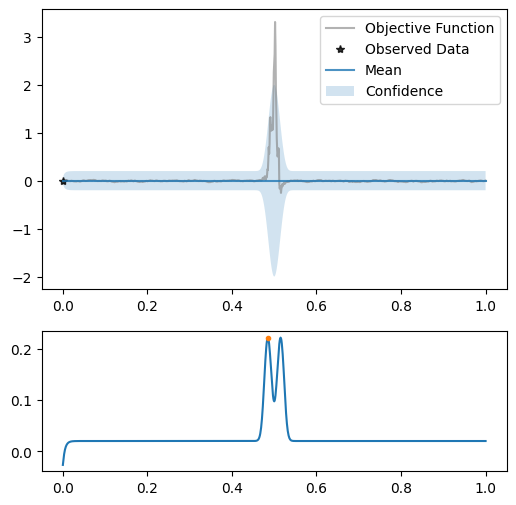

Iteration: 0
best oberved value: 0.007566416789224684
new point: [[0.48492111]]
new value: 0.28997463478936836
new acq: 0.22172036912728643
lmbda: tensor(0.3386)

new cost: 0.4047820411766839
cumulative cost: 0.4047820411766839


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1488]), std = tensor([0.1997])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


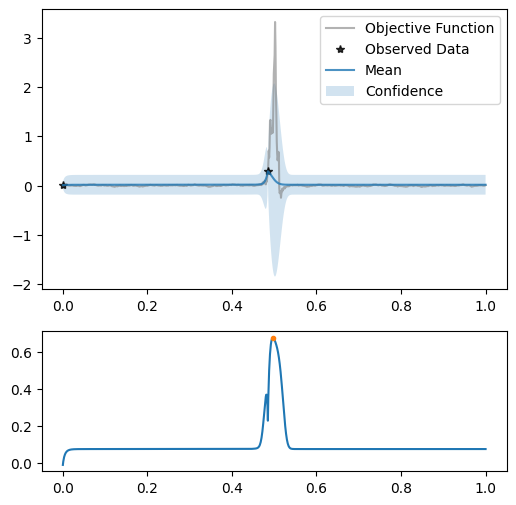

Iteration: 1
best oberved value: 0.28997463478936836
new point: [[0.49678817]]
new value: 1.33037528944739
new acq: 0.6772470779931683
lmbda: tensor(0.1669)

new cost: 1.0022419075200253
cumulative cost: 1.4070239486967093


In [10]:
from pandora_bayesopt.acquisition import GittinsIndex

maximize = True
dim = 1
budget = 1+delta

x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GI_best = [best_f] # This will store the best value
cumulative_cost = 0
GI_cumulative_cost_history = [0]

i = 0

# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]], dtype=torch.float64)
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EIpu
    EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
    _, new_point_EIpu = optimize_acqf(
        acq_function=EIpu,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Optimize Gittins
    GI = GittinsIndex(model=model, lmbda=new_point_EIpu/2, maximize=maximize, cost=cost_function)
    new_point, new_point_GI = optimize_acqf(
        acq_function=GI,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    test_x = torch.linspace(0, 1, 1001, dtype=torch.float64)

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GI_acq = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GI_acq.detach().numpy(), '-', new_point.item(), new_point_GI.item(), '.')
    plt.show()

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GI.item())
    print("lmbda:", new_point_EIpu/2)
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GI_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    GI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### Note
- Actually this hyperparameter-free Gittins policy can also perform well when the budget is higher

### TODO
- Check if we need a smaller intial lambda for hyperparameter-free Gittins policy

## Test Gittins policy with a small constant lambda

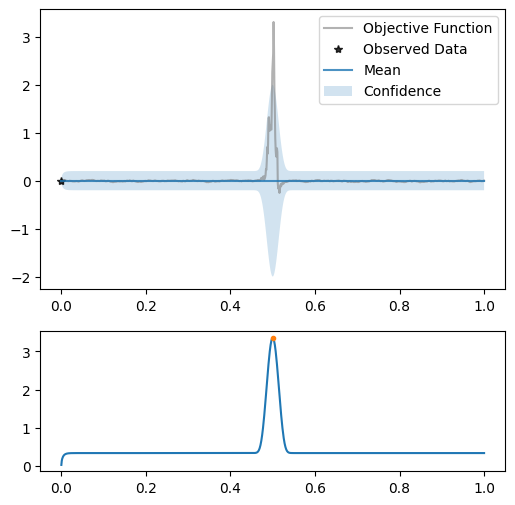

Iteration: 0
best oberved value: 0.007566416789224684
new point: [[0.5]]
new value: 2.449223298476082
new acq: 3.3579061022214134

new cost: 1.0499999999999994
cumulative cost: 1.0499999999999994


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.2284]), std = tensor([1.7265])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


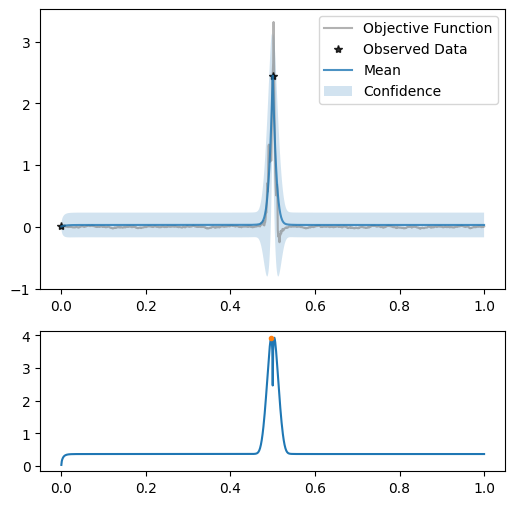

Iteration: 1
best oberved value: 2.449223298476082
new point: [[0.49636489]]
new value: 1.0212690360785996
new acq: 3.9337284354437045

new cost: 0.9892618459940651
cumulative cost: 2.0392618459940643


In [11]:
maximize = True
dim = 1
x = torch.zeros(dim).unsqueeze(1)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIlmbda_best = [best_f] # This will store the best value
cumulative_cost = 0
GIlmbda_cumulative_cost_history = [0]

i = 0

# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]], dtype=torch.float64)
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize Gittins
    GIlmbda = GittinsIndex(model=model, lmbda=0.0001, maximize=maximize, cost=cost_function)
    new_point, new_point_GIlmbda = optimize_acqf(
        acq_function=GIlmbda,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    test_x = torch.linspace(0, 1, 1001, dtype=torch.float64)

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GIlmbda_acq = GIlmbda.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GIlmbda_acq.detach().numpy(), '-', new_point.item(), new_point_GIlmbda.item(), '.')
    plt.show()

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GIlmbda.item())
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIlmbda_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    GIlmbda_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Plot best observed vs cumulative cost until the budget=1+delta

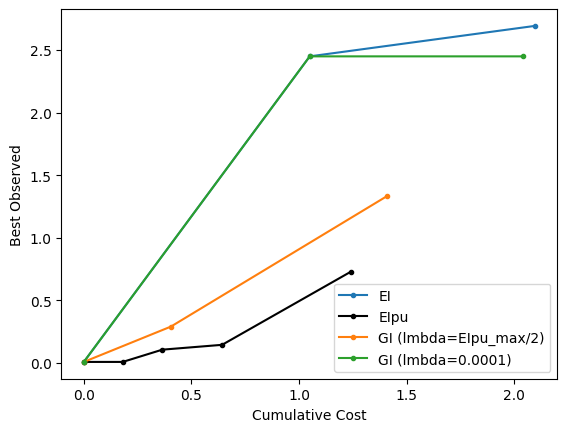

In [12]:
plt.plot(EI_cumulative_cost_history, EI_best, '.-', label="EI")
plt.plot(EIpu_cumulative_cost_history, EIpu_best, '.-', label="EIpu", color='black')
plt.plot(GI_cumulative_cost_history, GI_best, '.-', label="GI (lmbda=EIpu_max/2)")
plt.plot(GIlmbda_cumulative_cost_history, GIlmbda_best, '.-', label="GI (lmbda=0.0001)")
plt.xlabel('Cumulative Cost')
plt.ylabel('Best Observed')
plt.legend()

### Question
- Shall we caculate the average regret rather than the average best observed value across different instances?

- Shall we set a larger budget?

### TODO
- A sweep with different smoothness, lengthscales and seeds